# Test File for Ising Model Approximations
Nathan Burwig - Tufts SP23

---

The primary goal of this file is to serve as a test file for different Ising model approximations. To start, we will make an attempt at the simplest algorithm, the Metropolis algorithm, in which we simply switch each spin one at a time and determine how it changes the energy.

First, we will need to initialize our state...

In [2]:
%matplotlib inline
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy.signal import convolve2d
from scipy import constants

## 1D Metropolis (a bit messy)
---

In [3]:
## constants
N = 8
J = 1

my_state = np.array([1, -1, 1, -1, -1, 1, 1, 1])

In [4]:
## initializes a state of size NxN (2D)
def initialize(n):
    lattice = 2 * np.random.randint(2, size=(n))-1
    return lattice


In [5]:
initialize(10)

array([ 1, -1,  1,  1,  1, -1, -1,  1,  1,  1])

Quick test to see if we are getting values only of -1 and 1 like we hoped...

For now we have the random moving down fine, but I just realized we need an actual way to calculate the energy of the Hamiltonian... 

In order to do so we need to utilize the following:

$$ H = -J \sum_i S_{ij}\sigma_i \sigma_j$$

In [6]:
def calc_energy(state, j):
    interaction = 0
    for spin in range(len(state)-1):
        interaction = interaction + state[spin] * state[spin + 1]
        
    h = -j * interaction
    #print("energy calc for:", state)
    # print("energy:", h)
    return h

In [7]:
calc_energy(my_state, J)

1

Great! So at least for this smaller 1D example, we are recovering the expected energy as...

\begin{align*}
H &= -J \left(1*-1 + -1*1 + 1*-1 + -1*-1 + -1*-1 + -1*1 + 1*1 + 1*1 \right) \\
H &= -J \left(-1 + -1 + -1 + 1 + -1 + 1 + 1 \right) \\
H &=  J
\end{align*}

So for the 1D, we are now able to calculate energy, so we can go on to try finding the minimum possible energy.

Now we can start thinking about how to randomly pick sites and start flipping these spins...

We want to randomly move to a location and then flip the spin at that site, then randomly move to another location and do the same...

In [8]:
## randomly move to a new site and flip signs
## note we need b here for the exponential term involved in the sign flip
## paramters:
##      state - the configuration of spins
##      b     - the beta value
##      j     - the exchange parameter
def find_min_energy_2(state, b, j, t):
    lowest_state = state
    lowest_energy = calc_energy(state, j)

    # calc energy
    curr_energy = calc_energy(state, j)

    # pick a random site on the lattice
    i = np.random.randint(0, N)
    #print("site:", i, "\n\tstate:", state, "\n\tenergy:", curr_energy)

    # flip state at randomly chose site
    state[i] = state[i] * -1

    # calculate energy of lattice with flipped spin of random site
    flip_energy = calc_energy(state, j)
    #print("\tflip energy:", flip_energy)

    # change in energy
    delta_e = flip_energy - curr_energy
    #print("\tdelta e:", delta_e)

    # if change in energy is negative, change the lowest energy value
    # else flip the state back and move on
    if delta_e < 0 or np.random.rand() < np.e ** (-delta_e/(b * t)):
        #print("\tif")
        lowest_energy = flip_energy
        lowest_state = state
    else:
        #print("\telse")
        state[i] = state[i] * -1

    return lowest_energy, lowest_state

In [9]:
find_min_energy_2(my_state, 1, J, 5)

(1, array([ 1, -1,  1, -1, -1, -1,  1,  1]))

In [10]:
def calc_mag(state):
    return np.sum(state)

calc_mag(my_state.copy())

0

[-1 -1 -1 -1 -1 -1  1  1  1  1]


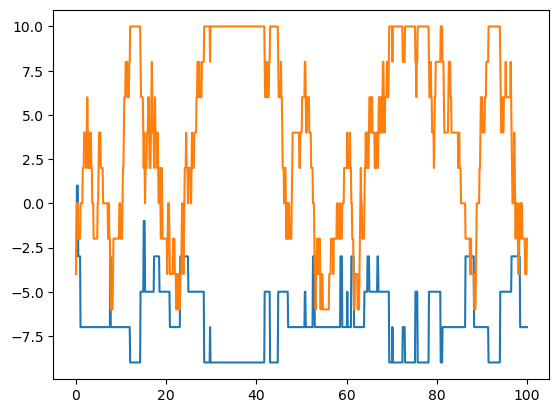

In [11]:
T = np.linspace(0, 100, 1000)
vals_e = []
vals_m = []

alpha = initialize(10)

for i in range(0, 1000):
    ## you fucking idiot you're using the same array on each call :(((
    val, new_alpha = find_min_energy_2(alpha, 1, J, 1)

    vals_e.append(val)

    vals_m.append(calc_mag(alpha))
    alpha = new_alpha

plt.plot(T, vals_e)
plt.plot(T, vals_m)
print(alpha)

Okay look so it's only maybe functioning for the 1D case, but I think it will actually be easier to determine if it is functioning in a 2D case, so let's try that out.

## 2D Metropolis
---

In [12]:
def init_latt_2d(n):
    ## initializes a state of size NxN (2D)
    lattice = 2 * np.random.randint(2, size=(n,n))-1
    return lattice


In [13]:
def cmap_latt_2d(state, energy):
    plt.imshow(state)
    plt.tick_params(left=False, bottom=False, labelbottom=False, labelleft=False)
    plt.title("lattics @ energy -> " + str(energy))

In [14]:
def metro_move_2d(state):
    i = np.random.randint(0, len(state))
    j = np.random.randint(0, len(state))

    new_state = state.copy()
    new_state[i, j] = new_state[i, j] * -1

    return new_state

In [15]:
def calc_energy_2d(state, j, debug=False):
    filter = np.array([[0,1,0],
                       [1,0,1],
                       [0,1,0]])

    conv_state = convolve2d(state, filter, mode="same")
    
    if debug:
        print("state:\n", state)
        print("filter:\n", filter)
        print("convolved:\n", conv_state)

    energy = 0

    for i in range(len(state)):
        for k in range(len(state)):
            energy += conv_state[i, k] * state[i, k]
        
    return energy * j * -1

In [16]:
def calc_mag_2d(state):
    return np.sum(state)

In [17]:
def metro_2d(latt, b=1, j=1, t=0.01, debug=False):
    state = latt
    n = len(state)

    x = np.random.randint(0, n)
    y = np.random.randint(0, n)
    site = state[x, y]


    if x == 0:
        del_x = -1 * j * (-1*site * state[x + 1, y])
    elif x == n - 1:
        del_x = -1 * j * (state[x - 1, y] * -1*site)
    else:
        del_x = -1 * j * (state[x - 1, y] * -1*site + state[x + 1, y] * -1*site)

    if y == 0:
        del_y = -1 * j * (-1*site * state[x, y + 1])
    elif y == n - 1:
        del_y = -1 * j * (state[x, y - 1] * -1*site)
    else:
        del_y = -1 * j * (state[x, y - 1] * -1*site + state[x, y + 1] * -1*site)

    delta_e = (del_x + del_y)
        

    rando = rand()

    if delta_e < 0 or rando < np.e**(-delta_e / (b * t)):
        if debug:
            print("randval:\t", rand())
            print("exponent:\t", np.e**(-delta_e / (b * t)))
        state[x, y] *= -1
    
    return state


A quick test run

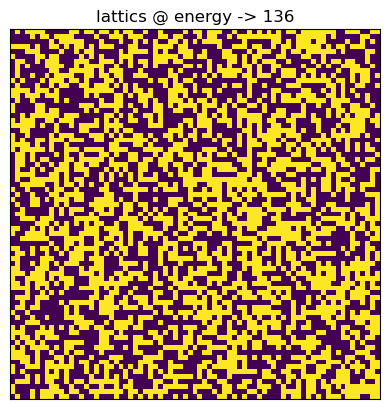

In [18]:
test_state = init_latt_2d(75)
cmap_latt_2d(test_state, calc_energy_2d(test_state, 1))

This is the main loop

Text(0, 0.5, 'energy')

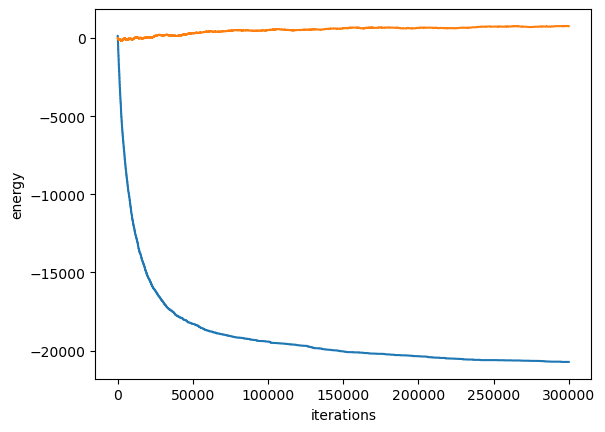

In [31]:
e_vals = []
m_vals = []

steps = 300000
domain = np.linspace(0, steps, steps)

my_state = test_state.copy()
e_vals.append(calc_energy_2d(my_state, 1))
m_vals.append(calc_mag_2d(my_state))

for i in range(0, steps - 1):
    new_state = metro_2d(my_state, b=constants.k, t=1000)
    new_energy = calc_energy_2d(new_state, 1)

    e_vals.append(new_energy)
    m_vals.append(calc_mag_2d(new_state))
    
    my_state = new_state


plt.plot(domain, e_vals)
plt.plot(domain, m_vals)

plt.xlabel("iterations")
plt.ylabel("energy")


At a first glance, this seems to work to some degree or another

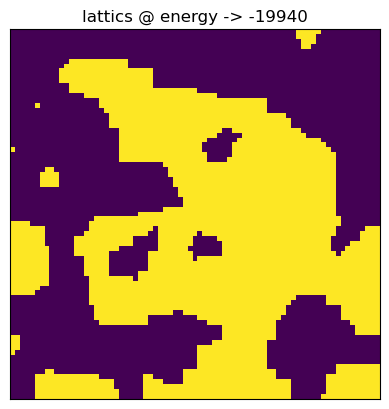

In [29]:
cmap_latt_2d(my_state, new_energy)

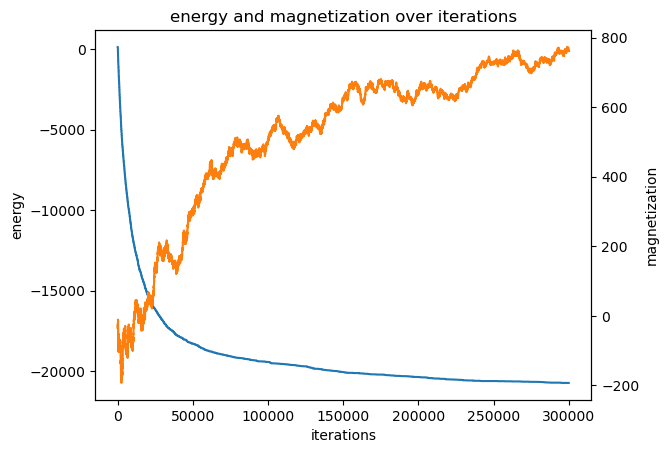

In [33]:
fig, ax1 = plt.subplots()
 
color = 'tab:blue'
ax1.set_xlabel('iterations')
ax1.set_ylabel('energy')
ax1.plot(range(0, steps), e_vals, color = color)
ax1.tick_params(axis ='y')
 
# Adding Twin Axes to plot using dataset_2
ax2 = ax1.twinx()
 
color = 'tab:orange'
ax2.set_ylabel('magnetization')
ax2.plot(range(0, steps), m_vals, color = color)
ax2.tick_params(axis ='y')
 
# Adding title
plt.title('energy and magnetization over iterations')
 
# Show plot
plt.show()

## Wolff attempt 1 (2D)
---

The Wolff Algorithm is a bit different from the Metropolis algorithm. Most notably, Wolff is a cluster algorithm which means that it changes large clusters of groups that are of like spin. So instead of just flipping one random bit, we now have to worry about flipping the surrounding bits as well. Importantly, there is an associated probability of flipping a neighbor spin, so we won't just be flipping all the spins in case there is a large number of connected spins.

Lets try it out...

In [21]:
def neighbor_sites(state, x, y):
    if x == 0:
        


IndentationError: expected an indented block (1078828543.py, line 3)

In [ ]:
def wolff_2d(state, b=1, j=1, t=4):
    # start with random initial position
    n = len(state)

    x = np.random.randint(0, n)
    y = np.random.randint(0, n)

    site = state[x, y]

    